<a href="https://colab.research.google.com/github/dmat/fakenewsdetection/blob/main/FNID_FakeNewsDetection_with_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np  
import re 
import nltk 
nltk.download('punkt')
nltk.download('wordnet')
import wordcloud 
from wordcloud import WordCloud
import statistics
import string
from collections import Counter
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score
import torch
import torch.nn as nn
import seaborn as sns 
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = list(stopwords.words('english'))
stop_words.extend(["said", "reuters", "CNN", "would", "image", "via", "say","state","year", "tax"]) #extend stopwords to include these words too

Mounted at /content/drive
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# load the training and testing data
data_train = pd.read_csv('/content/drive/My Drive/SML/fake news detection/fnn_train.csv')
data_test = pd.read_csv('/content/drive/My Drive/SML/fake news detection/fnn_test.csv')
data_dev = pd.read_csv('/content/drive/My Drive/SML/fake news detection/fnn_dev.csv')

In [ ]:
# convert the data labels into categorical variables (real = 0, fake = 1)
data_train["label_fnn"] = data_train["label_fnn"].replace("real",0)
data_train["label_fnn"] = data_train["label_fnn"].replace("fake",1)
data_test["label_fnn"] = data_test["label_fnn"].replace("real",0)
data_test["label_fnn"] = data_test["label_fnn"].replace("fake",1)
data_dev["label_fnn"] = data_dev["label_fnn"].replace("real",0)
data_dev["label_fnn"] = data_dev["label_fnn"].replace("fake",1)

In [ ]:
# check for any null data in the datset
data_train.isnull().sum()
data_train.info()

data_test.isnull().sum()
data_test.info()

data_dev.isnull().sum()
data_dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15212 entries, 0 to 15211
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       15212 non-null  int64 
 1   date                     15212 non-null  object
 2   speaker                  15212 non-null  object
 3   statement                15212 non-null  object
 4   sources                  15212 non-null  object
 5   paragraph_based_content  15212 non-null  object
 6   fullText_based_content   15212 non-null  object
 7   label_fnn                15212 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 950.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054 entries, 0 to 1053
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       1054 non-null   int64 
 1   date                     1054 non-null  

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


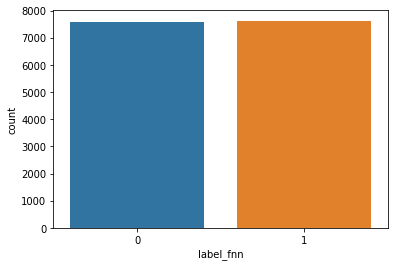

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


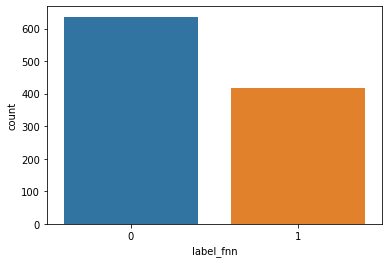

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


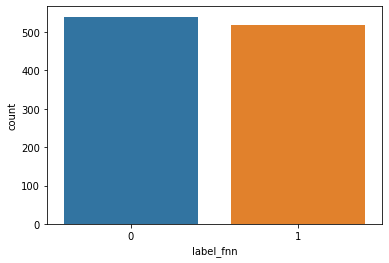

In [ ]:
# visualize if the dataset is balanced
sns.countplot(data_train["label_fnn"])
plt.show()

sns.countplot(data_test["label_fnn"])
plt.show()

sns.countplot(data_dev["label_fnn"])
plt.show()

In [ ]:
# drop the date column and create dummies for sources of news
data_train = data_train.drop("date", axis=1)
#data_train = pd.get_dummies(data_train,columns=["sources"])
data_train.head()

data_test = data_test.drop("date", axis=1)
#data_test = pd.get_dummies(data_test,columns=["sources"])
data_test.head()

data_dev = data_dev.drop("date", axis=1)
#data_test = pd.get_dummies(data_test,columns=["sources"])
data_dev.head()

,id,speaker,statement,sources,paragraph_based_content,fullText_based_content,label_fnn
0,1636,Charlie Crist,"Rubio's tax swap proposal ""would have been a m...",['http://blogs.tampabay.com/buzz/files/040307l...,['Gov. Charlie Crist launched what amounts to ...,Gov. Charlie Crist launched what amounts to a ...,1
1,4352,Bobby Scott,"""The estimated savings of this (debt ceiling) ...",['http://www.bobbyscott.house.gov/index.php?op...,"['U.S. Rep. Bobby Scott, D-3rd, was not please...","U.S. Rep. Bobby Scott, D-3rd, was not pleased ...",0
2,16471,Wisconsin Republican Legislative leaders,"Foxconn has already ""made a positive impact ac...",['https://www.wispolitics.com/2019/sen-fitzger...,"[""Amid reports questioning Foxconn Technology ...",Amid reports questioning Foxconn Technology Gr...,1
3,1557,Dave Aronberg,"Says Gov. Charlie Crist has called him ""a rock...","['http://www.davearonberg.com/about', 'http://...","[""State Sen. Dave Aronberg, a Democratic candi...","State Sen. Dave Aronberg, a Democratic candida...",0
4,12826,Jeannette Vaught,"""Only five Texas counties account for almost 9...",['http://www.mystatesman.com/news/news/opinion...,['From the citrus of the Rio Grande Valley to ...,From the citrus of the Rio Grande Valley to th...,1


In [ ]:
# drop the columns which are not required
print(data_train)
data_train.info()
data_train = data_train.drop(["speaker", "fullText_based_content"],axis=1)

print(data_test)
data_test.info()
data_test = data_test.drop(["speaker", "fullText_based_content"],axis=1)

print(data_dev)
data_dev.info()
data_dev = data_dev.drop(["speaker", "fullText_based_content"],axis=1)


          id  ... label_fnn
0       3106  ...         1
1       5655  ...         1
2       3506  ...         1
3       3450  ...         0
4       4776  ...         1
...      ...  ...       ...
15207   7125  ...         0
15208  17742  ...         1
15209  16988  ...         1
15210   5758  ...         1
15211  16941  ...         0

[15212 rows x 7 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15212 entries, 0 to 15211
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       15212 non-null  int64 
 1   speaker                  15212 non-null  object
 2   statement                15212 non-null  object
 3   sources                  15212 non-null  object
 4   paragraph_based_content  15212 non-null  object
 5   fullText_based_content   15212 non-null  object
 6   label_fnn                15212 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 832.0+ KB
 

In [ ]:
data_train.head()

In [ ]:
#vectorise content
new_text_train = []
pattern = "[^a-zA-Z]"
lemma = nltk.WordNetLemmatizer()

for txt in data_train.paragraph_based_content:
    
    txt = re.sub(pattern," ",txt) # Cleaning
    txt = txt.lower() # Lowering
    txt = nltk.word_tokenize(txt) # Tokenizing
    txt = [lemma.lemmatize(word) for word in txt] # Lemmatizing
    txt = " ".join(txt)
    new_text_train.append(txt)

new_text_test = []
for txt in data_test.paragraph_based_content:
    
    txt = re.sub(pattern," ",txt) # Cleaning
    txt = txt.lower() # Lowering
    txt = nltk.word_tokenize(txt) # Tokenizing
    txt = [lemma.lemmatize(word) for word in txt] # Lemmatizing
    txt = " ".join(txt)
    new_text_test.append(txt)

    new_text_dev = []
for txt in data_dev.paragraph_based_content:
    
    txt = re.sub(pattern," ",txt) # Cleaning
    txt = txt.lower() # Lowering
    txt = nltk.word_tokenize(txt) # Tokenizing
    txt = [lemma.lemmatize(word) for word in txt] # Lemmatizing
    txt = " ".join(txt)
    new_text_dev.append(txt)

In [ ]:
#vectorise statement
new_title_train = []
for txt in data_train.statement:
    
    txt = re.sub(pattern," ",txt) # Cleaning
    txt = txt.lower() # Lowering
    txt = nltk.word_tokenize(txt) # Tokenizing
    txt = [lemma.lemmatize(word) for word in txt] # Lemmatizing
    txt = " ".join(txt)
    new_title_train.append(txt)

new_title_test = []
for txt in data_test.statement:
    
    txt = re.sub(pattern," ",txt) # Cleaning
    txt = txt.lower() # Lowering
    txt = nltk.word_tokenize(txt) # Tokenizing
    txt = [lemma.lemmatize(word) for word in txt] # Lemmatizing
    txt = " ".join(txt)
    new_title_test.append(txt)

new_title_dev = []
for txt in data_dev.statement:
    
    txt = re.sub(pattern," ",txt) # Cleaning
    txt = txt.lower() # Lowering
    txt = nltk.word_tokenize(txt) # Tokenizing
    txt = [lemma.lemmatize(word) for word in txt] # Lemmatizing
    txt = " ".join(txt)
    new_title_dev.append(txt)


In [ ]:
print(new_title_train)

In [ ]:
data_train_fake = data_train[data_train['label_fnn'] == 0]
data_train_true = data_train[data_train['label_fnn'] == 1]


In [ ]:
data_train_fake.head()

In [ ]:
lemmatizer = WordNetLemmatizer()  

words_in_t = [] #all tokens in true articles
words_in_f = [] #all tokens in fake articles
words_in_each_article_t = [] #list of true articles, each in tokenized form
words_in_each_article_f = [] #list of fake articles, each in tokenized form

def process(df, word_list, by_article_list):
  for article in (df["paragraph_based_content"]):
    words = word_tokenize(article)
    words = [word.lower() for word in words if word.isalpha()] #lowercase
    words = [word for word in words if word not in string.punctuation and word not in stop_words] #punctuation, stopwords
    words = [lemmatizer.lemmatize(word) for word in words] #convert word to root form

    by_article_list.append(words)
    for w in words:
      word_list.append(w)

In [ ]:
#NOTE: If rerunning, this cell will take a while
process(data_train_fake, words_in_f, words_in_each_article_f)
process(data_train_true, words_in_t, words_in_each_article_t)
print(words_in_t)

In [ ]:
wordcounts_true = Counter(words_in_t)
wordcounts_false = Counter(words_in_f)

mostcommon_t = Counter(wordcounts_true).most_common(50)
mostcommon_f = Counter(wordcounts_false).most_common(50)
print(mostcommon_t)
print(mostcommon_f)


In [ ]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="wordcounts_true", y="words_in_t")

In [ ]:
t_plot = dict(mostcommon_t)
mostcommon_t = pd.DataFrame(mostcommon_t, columns = ["Word", "Count"])
mostcommon_t = mostcommon_t.reset_index(drop=True)
mostcommon_t = mostcommon_t['Word'].tolist()

f_plot = dict(mostcommon_f)
mostcommon_f = pd.DataFrame(mostcommon_f, columns = ["Word", "Count"])
mostcommon_f = mostcommon_f.reset_index(drop=True)
mostcommon_f = mostcommon_f['Word'].tolist()

In [ ]:
t_wc = WordCloud(max_words=50,relative_scaling=1,background_color ='white', normalize_plurals=False).generate_from_frequencies(t_plot)

plt.imshow(t_wc)
plt.title("Plot of Most Frequent Words in Real News")
plt.show()

In [ ]:
f_wc = WordCloud(max_words=50,relative_scaling=1,background_color ='white', normalize_plurals=False).generate_from_frequencies(f_plot)

plt.imshow(f_wc)
plt.title("Plot of Most Frequent Words in Fake News")
plt.show()

In [ ]:
#Both types of articles are around the same length in words, on average
words_per_article_plot_t = data_train_true["paragraph_based_content"].apply(lambda x: len(x.split()))
stdev_t = statistics.stdev(words_per_article_plot_t)
words_per_article_t = words_per_article_plot_t.sum()/len(data_train_true["paragraph_based_content"])

words_per_article_plot_f = data_train_fake["paragraph_based_content"].apply(lambda x: len(x.split()))
stdev_f = statistics.stdev(words_per_article_plot_f)
words_per_article_f = words_per_article_plot_f.sum()/len(data_train_fake["paragraph_based_content"])

print ("The average number of words in a real news article is ", words_per_article_t)
print ("The average number of words in a fake news article is ", words_per_article_f)

print ("The standard deviation in real news article lengths is ", stdev_t)
print ("The standard deviation in fake news article lengths is ", stdev_f)

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
sns.distplot(words_per_article_plot_t, ax = ax[0], color = "darkblue", rug = True).set_title("Number of Words in Real News Article")
sns.distplot(words_per_article_plot_f, ax = ax[1], color = "red", rug = True).set_title("Number of Words in Fake News Article")

In [ ]:
#Both types of articles are around the same length in words, on average
words_per_headline_plot_t = data_train_true["statement"].apply(lambda x: len(x.split()))
stdev_t = statistics.stdev(words_per_headline_plot_t)
words_per_headline_t = words_per_headline_plot_t.sum()/len(data_train_true["statement"])

words_per_headline_plot_f = data_train_fake["statement"].apply(lambda x: len(x.split()))
stdev_f = statistics.stdev(words_per_headline_plot_f)
words_per_headline_f = words_per_headline_plot_f.sum()/len(data_train_fake["statement"])

print ("The average number of words in a real news headline is ", words_per_headline_t)
print ("The average number of words in a fake news headline is ", words_per_headline_f)

print ("The standard deviation in real news headline lengths is ", stdev_t)
print ("The standard deviation in fake news headline lengths is ", stdev_f)

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
sns.distplot(words_per_headline_plot_t, ax = ax[0], color = "darkblue", rug = True).set_title("Number of Words in Real News Headline")
sns.distplot(words_per_headline_plot_f, ax = ax[1], color = "red", rug = True).set_title("Number of Words in Fake News Headline")

In [ ]:
#create sparse matrix
vectorizer_title = CountVectorizer(stop_words="english",max_features=1000)
vectorizer_text = CountVectorizer(stop_words="english",max_features=4000)

title_matrix_train = vectorizer_title.fit_transform(new_title_train).toarray() 
title_matrix_test = vectorizer_title.fit_transform(new_title_test).toarray()
title_matrix_dev = vectorizer_title.fit_transform(new_title_dev).toarray()

text_matrix_train = vectorizer_text.fit_transform(new_text_train).toarray()
text_matrix_test = vectorizer_text.fit_transform(new_text_test).toarray()
text_matrix_dev = vectorizer_text.fit_transform(new_text_dev).toarray()
data_train.head()
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15212 entries, 0 to 15211
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       15212 non-null  int64 
 1   statement                15212 non-null  object
 2   sources                  15212 non-null  object
 3   paragraph_based_content  15212 non-null  object
 4   label_fnn                15212 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 594.3+ KB


In [ ]:
print(data_train)

          id  ... label_fnn
0       3106  ...         1
1       5655  ...         1
2       3506  ...         1
3       3450  ...         0
4       4776  ...         1
...      ...  ...       ...
15207   7125  ...         0
15208  17742  ...         1
15209  16988  ...         1
15210   5758  ...         1
15211  16941  ...         0

[15212 rows x 5 columns]


In [ ]:
# create the train and test matrix
Y_train = data_train.label_fnn
X_train = np.concatenate((np.array(data_train.drop(["id","statement","sources","paragraph_based_content","label_fnn"],axis=1)),title_matrix_train,text_matrix_train),axis=1)

Y_test = data_test.label_fnn
X_test = np.concatenate((np.array(data_test.drop(["id","statement","sources","paragraph_based_content","label_fnn"],axis=1)),title_matrix_test,text_matrix_test),axis=1)

Y_dev = data_dev.label_fnn
X_dev = np.concatenate((np.array(data_dev.drop(["id","statement","sources","paragraph_based_content","label_fnn"],axis=1)),title_matrix_dev,text_matrix_dev),axis=1)


In [ ]:
print(title_matrix_train)

In [ ]:
# Converting numpy arrays into pytorch tensors
X_train = torch.Tensor(X_train)

# You must convert it into LongTensor
Y_train = torch.Tensor(Y_train).type(torch.LongTensor)

X_test = torch.Tensor(X_test)
Y_test = torch.Tensor(Y_test)

X_dev = torch.Tensor(X_dev)
Y_dev = torch.Tensor(Y_dev)

print(X_train)
print(X_test)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [ ]:
# logistic regression
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [ ]:
# fit logistic regression model
modelLG = LogisticRegression(solver = 'liblinear',random_state=0)
modelLG = modelLG.fit(X_train, Y_train)

#predict using logistic regression model on testing dataset
ypred_lg_train = modelLG.predict(X_train)

In [ ]:
# Classification report on training dataset
print(classification_report(Y_train, ypred_lg_train))

              precision    recall  f1-score   support

           0       0.88      0.89      0.88      7591
           1       0.89      0.88      0.88      7621

    accuracy                           0.88     15212
   macro avg       0.88      0.88      0.88     15212
weighted avg       0.88      0.88      0.88     15212



In [ ]:
ypred_lg_test = modelLG.predict(X_test)

In [ ]:
# Classification report on testing dataset
print(classification_report(Y_test, ypred_lg_test))

              precision    recall  f1-score   support

         0.0       0.58      0.60      0.59       636
         1.0       0.36      0.34      0.35       418

    accuracy                           0.50      1054
   macro avg       0.47      0.47      0.47      1054
weighted avg       0.49      0.50      0.50      1054



In [ ]:
ypred_lg_dev = modelLG.predict(X_dev)

In [ ]:
# Classification report on testing dataset
print(classification_report(Y_dev, ypred_lg_dev))

              precision    recall  f1-score   support

         0.0       0.51      0.48      0.50       540
         1.0       0.49      0.52      0.51       518

    accuracy                           0.50      1058
   macro avg       0.50      0.50      0.50      1058
weighted avg       0.50      0.50      0.50      1058



In [ ]:
from sklearn import metrics
lg_cm = metrics.confusion_matrix(Y_test, ypred_lg_test)
print(lg_cm)

[[384 252]
 [277 141]]


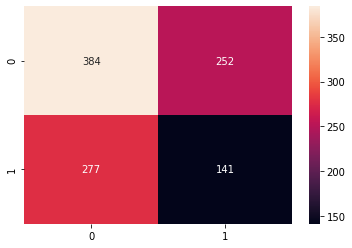

In [ ]:
labels =  np.array([['384','252'],['277','141']])
sns.heatmap(lg_cm, annot=labels, fmt = '')
plt.show()

In [ ]:
print (metrics.roc_auc_score(Y_test, ypred_lg_test))

0.47054707953416985


In [ ]:
from sklearn.naive_bayes import GaussianNB
# Fit a model using Naive Bayes
modelNB = GaussianNB()
modelNB.fit(X_train, Y_train)

# Predict using the training dataset
modelNB.predict(X_train)

array([1, 1, 0, ..., 1, 1, 0])

In [ ]:
# Classification report on training dataset
print(classification_report(Y_train, modelNB.predict(X_train)))

              precision    recall  f1-score   support

           0       0.70      0.76      0.73      7591
           1       0.74      0.67      0.70      7621

    accuracy                           0.72     15212
   macro avg       0.72      0.72      0.71     15212
weighted avg       0.72      0.72      0.71     15212



In [ ]:
# Predict using the testing dataset
modelNB.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
# Classification report on testing dataset
print(classification_report(Y_test, modelNB.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.39      0.26      0.31       636
         1.0       0.25      0.37      0.30       418

    accuracy                           0.31      1054
   macro avg       0.32      0.32      0.31      1054
weighted avg       0.33      0.31      0.31      1054



In [ ]:
# fit SVM model on the training dataset
from sklearn.svm import LinearSVC
modelSVM = LinearSVC(random_state=0)
modelSVM.fit(X_train, Y_train)

ypred_svm_train = modelSVM.predict(X_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
print(classification_report(Y_train, ypred_svm_train)

SyntaxError: ignored

In [ ]:
ypred_svm_test = modelSVM.predict(X_test)

In [ ]:
# Classification report on testing dataset
print(classification_report(Y_test, ypred_svm_test))

In [ ]:
svm_cm = metrics.confusion_matrix(Y_test, ypred_svm_test)
print(svm_cm)

In [ ]:
labels =  np.array([['4005','517'],['471','4348']])
sns.heatmap(svm_cm, annot=labels, fmt = '')
plt.show()

In [ ]:
print (metrics.roc_auc_score(Y_test, ypred_lg_train))

In [ ]:
class ANN(nn.Module):
    
    def __init__(self):
        
        super(ANN,self).__init__() # Inhertiting
        
        self.linear1 = nn.Linear(5000,3000) # IN 5008 OUT 2000
        self.relu1 = nn.ReLU() # Actfunc 1
        
        self.linear2 = nn.Linear(3000,1500) # IN 2000 OUT 500
        self.relu2 = nn.ReLU()
        
        self.linear3 = nn.Linear(1500,300) # IN 500 OUT 100
        self.relu3 = nn.ReLU()
        
        self.linear4 = nn.Linear(300,50) # IN 100 OUT 20
        self.relu4 = nn.ReLU()
        
        self.linear5 = nn.Linear(50,2) # IN 20 OUT 2 | OUTPUT 
        
    
    def forward(self,x):
        
        out = self.linear1(x) # Input Layer 
        out = self.relu1(out)
        
        out = self.linear2(out) # Hidden Layer 1 
        out = self.relu2(out)
        
        out = self.linear3(out) # Hidden Layer 2 
        out = self.relu3(out)
        
        out = self.linear4(out) # Hidden Layer 3 
        out = self.relu4(out)

        
        out = self.linear5(out) # Output Layer
        
        return out
    

modelANN = ANN()
optimizer = torch.optim.Adam(modelANN.parameters(),lr=0.01)
error = nn.CrossEntropyLoss()

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    
    # Clearing gradients
    optimizer.zero_grad()
    
    # Forward Propagation
    outs = modelANN(X_train)
    
    # Computing Loss
    loss = error(outs,Y_train)
    
    # Backward propagation
    loss.backward()
    
    # Updating parameters
    optimizer.step()
    
    # Printing loss
    print(f"Loss after iteration {epoch} is {loss}")

Loss after iteration 0 is 0.693307638168335
Loss after iteration 1 is 25.57130241394043
Loss after iteration 2 is 53.79549026489258
Loss after iteration 3 is 4.528623104095459
Loss after iteration 4 is 3.7471795082092285


In [ ]:
y_head = modelANN(X_test)
print(y_head[0])
# Converting Prediction into labels
y_predANN = torch.max(y_head,1)[1]
print(y_predANN[0])

tensor([0.1701, 0.0907], grad_fn=<SelectBackward>)
tensor(0)


In [ ]:
print("Model accuracy is ",accuracy_score(y_predANN,Y_test))

Model accuracy is  0.603415559772296


In [ ]:
y_head = modelANN(X_train)
print(y_head[0])
# Converting Prediction into labels
y_predANNt = torch.max(y_head,1)[1]
print(y_predANNt[0])

tensor([0.1701, 0.0907], grad_fn=<SelectBackward>)
tensor(0)


In [ ]:
print("Model accuracy is ",accuracy_score(y_predANNt,Y_train))

Model accuracy is  0.4990139363660268


In [ ]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
prediction_sgd = sgd.predict(X_test)
print (classification_report(Y_test, prediction_sgd))

              precision    recall  f1-score   support

         0.0       0.56      0.59      0.57       636
         1.0       0.32      0.29      0.30       418

    accuracy                           0.47      1054
   macro avg       0.44      0.44      0.44      1054
weighted avg       0.46      0.47      0.47      1054



In [ ]:
from sklearn import metrics
sgd_cm = metrics.confusion_matrix(Y_test, prediction_sgd)
print(sgd_cm)

[[376 260]
 [296 122]]


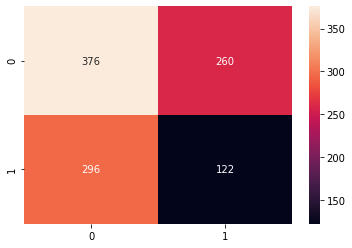

In [ ]:
labels =  np.array([['376','260'],['296','122']])
sns.heatmap(sgd_cm, annot=labels, fmt = '')
plt.show()

In [ ]:
from torch.autograd import Variable
epochs=50
learning_rate=0.01

In [ ]:
class Feedforwardnet(nn.Module):
    def __init__(self,input_size,hidden_sizes,activation):      
        super(Feedforwardnet, self).__init__()
        
        # input layer
        self.layers = input_size
        fc = []
        
        # activation function
        activationf = {
            'ReLU': nn.ReLU(),
            'Sigmoid': nn.Sigmoid(),
            'Tanh': nn.Tanh(),
            'Identity': lambda x:x}
        actf=[]
        
        for a in activation:
            actf.append(activationf[a])
            
        # output layer
        for i in range(self.layers+1):
            fc.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            
        self.fc = nn.ModuleList(fc)
        self.act = nn.ModuleList(actf)
           
    def forward(self,x):
        for i in range(len(self.fc)):
            x=self.fc[i](x)
            x=self.act[i](x)
        return x

In [ ]:
def train (x_trn, y_trn,x_tst,input_size ,hidden_size,activation):
    ##Setup FeedForward Neural Network
    model=Feedforwardnet(input_size,hidden_size,activation)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    #Transform Data
    x_train=Variable(torch.FloatTensor(x_trn))
    x_test=Variable(torch.FloatTensor(x_tst))
    y_train=np.squeeze(y_trn)
    y_train=torch.LongTensor(y_trn)
    
    #Train the model
    model.train()
    for epoch in range(epochs):
            optimizer.zero_grad()
            output = model(x_train)
            loss =criterion(output,y_train)
            loss.backward()
            optimizer.step()  
    
    # Parametes:Weights,Bias,Activation
    parameter=list(model.parameters())
    learned_weights=[]
    learned_bias=[]
    for i in range(len(parameter)):
        if i %2==0:
            learned_weights.append(parameter[i].detach().numpy())
        else: learned_bias.append(parameter[i].detach().numpy())
            
    activation=model(x_train).detach().numpy()
    
    
    model.eval()
    
    #Predict Train
    y_train_predict=model(x_train)
    train_predict=prediction(y_train_predict)
    
    #Predict Test
    y_test_predict=model(x_test)
    test_predict=prediction(y_test_predict)
    
    #Outputs Weights,Bias, Activation, 
    return learned_weights,learned_bias,activation,train_predict,test_predict

In [ ]:
# Function to predict variables
def prediction(predict):
    _, pred= torch.max(predict.data, 1)
    pred=pred.detach().numpy()
    return pred

In [ ]:
#Function to calculate Accuracy
def accuracy(Y_pred,Y_test):
    acc=0
    for i in range(len(Y_test)):
        if Y_pred[i]==Y_test[i]:
            acc +=1
    return (acc/len(Y_test))

In [ ]:
learned_weights,learned_bias,activation,train_predict,test_predict=train(X_train,Y_train,X_test,1,[5000,3000,2],['ReLU','Sigmoid'])

In [ ]:
print("The accuracy on Train dataset:",accuracy(train_predict,Y_train))
print("The classification error on the dataset is:",1-accuracy(train_predict,Y_train))

The accuracy on Train dataset: 0.49907967394162506
The classification error on the dataset is: 0.500920326058375


In [ ]:
print("The accuracy on test dataset:",accuracy(test_predict,Y_test))
print("The classification error on the dataset is:",1-accuracy(test_predict,Y_test))

The accuracy on test dataset: 0.603415559772296
The classification error on the dataset is: 0.396584440227704


In [ ]:
epochs=60

In [ ]:
learned_weights,learned_bias,activation,train_predict,test_predict=train(X_train,Y_train,X_test,3,[5000,3000,1000,100,2],['ReLU','ReLU','ReLU','Sigmoid'])

In [ ]:
print("The accuracy on Train dataset:",accuracy(train_predict,Y_train))
print("The classification error on the dataset is:",1-accuracy(train_predict,Y_train))

The accuracy on Train dataset: 0.4990139363660268
The classification error on the dataset is: 0.5009860636339731


In [ ]:
print("The accuracy on test dataset:",accuracy(test_predict,Y_test))
print("The classification error on the dataset is:",1-accuracy(test_predict,Y_test))

The accuracy on test dataset: 0.603415559772296
The classification error on the dataset is: 0.396584440227704


In [ ]:
learned_weights,learned_bias,activation,train_predict,test_predict=train(X_train,Y_train,X_test,4,[5000,3000,1000,500,100,2],['ReLU','ReLU','ReLU','ReLU','Sigmoid'])

In [ ]:
print("The accuracy on Train dataset:",accuracy(train_predict,Y_train))
print("The classification error on the dataset is:",1-accuracy(train_predict,Y_train))

The accuracy on Train dataset: 0.5009860636339731
The classification error on the dataset is: 0.49901393636602687


In [ ]:
print("The accuracy on test dataset:",accuracy(test_predict,Y_test))
print("The classification error on the dataset is:",1-accuracy(test_predict,Y_test))

The accuracy on test dataset: 0.396584440227704
The classification error on the dataset is: 0.603415559772296
